In [1]:
# Deep Learning with Python Ch6: Jena weather example
# inspect data
import os

# location of the raw data
data_dir = 'C:\\Users\\Carol\\Documents\\OneDrive\\Research\\Others\\Big Data\\DLP\\Ch06\\jena_climate'
fname    = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

# load data
f    = open(fname)
data = f.read()
f.close()

# clean up data
lines  = data.split('\n')
header = lines[0].split(',')
lines  = lines[1:]

print('variables:', header)
print('# of variables:', len(header))
print('# of obs:', len(lines))

variables: ['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
# of variables: 15
# of obs: 420551


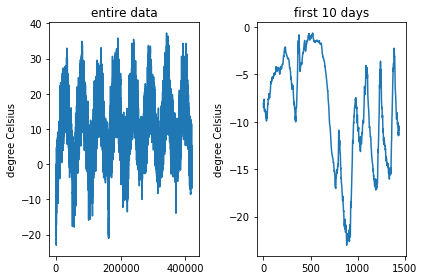

In [2]:
# convert data to numpy array: each line is a timestep
import numpy as np

float_data = np.zeros((len(lines), len(header)-1)) # drop 'Date Time'
for i, line in enumerate(lines):
    values           = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

# plot temperature data
%matplotlib inline
import matplotlib.pyplot as plt

temp = float_data[:, 1]
plt.subplot(1,2,1)
plt.plot(range(len(temp)), temp)
plt.title('entire data')
plt.ylabel('degree Celsius')

plt.subplot(1,2,2)
plt.plot(range(1440), temp[:1440])
plt.title('first 10 days')
plt.ylabel('degree Celsius')

plt.tight_layout()
plt.show()

In [3]:
# preprocess data
# use 1st 200,000 timesteps as training data
# then normalize 
mean        = float_data[:200000].mean(axis=0)
float_data -= mean
std         = float_data[:200000].std(axis=0)
float_data /= std

In [4]:
# generator yields timeseries samples and their targets
# data:           original data
# lookback:       # of timesteps the input data should go back
# delay:          # of timesteps the target shouold be in the future
# min/max_index:  delimit which timesteps to draw from
# shuffle:        False - draw chronologically; True - draw randomly
# batch_size:     # of samples per batch
# step:           the period in timesteps at which smaple data are drawn 
#                 (default: draw 1 data point per hour or (6 x 10) mins)
def generator(data, lookback, delay, min_index, max_index, 
              shuffle=False, batch_size=128, step=6):
    
    if max_index is None:
        max_index = len(data) - delay - 1
        
    i = min_index + lookback
    
    while 1: 
        if shuffle: 
            # if shuffle is True, then order no longer matters
            # so don't use i which gets updated each iteration
            # instead, just draw batch_size # of samples per iteration
            rows = np.random.randint(min_index+lookback, max_index, size=batch_size)
        else:
            if (i+batch_size) >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i+batch_size, max_index))
            i   += len(rows) # # of samples per iteration = len(rows)
        
        samples = np.zeros((len(rows), lookback//step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        
        for j, row in enumerate(rows):
            indices    = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j]+delay][1] # column 1 is temperature, 
                                                # aka what we're predicting (or target)
            
        yield samples, targets

# initiate generator for training, validation, and test data
lookback   = 1440 # look 10 days (= 10 x 24 x 60 mins) back
delay      = 144  # target 24 hours (= 24 x 60 mins) from now
step       = 6    # sample one point per hour = (60 mins)
batch_size = 128  # each batch has 128 samples

# 200,000 as training data
train_gen = generator(float_data, lookback=lookback, delay=delay, 
                      min_index=0, max_index=200000, shuffle=True, 
                      batch_size=batch_size, step=step)
# 100,000 as validation data
val_gen   = generator(float_data, lookback=lookback, delay=delay, 
                      min_index=200001, max_index=300000, shuffle=False, 
                      batch_size=batch_size, step=step)
# 100,000 as test data
test_gen  = generator(float_data, lookback=lookback, delay=delay, 
                      min_index=300001, max_index=None, shuffle=False, 
                      batch_size=batch_size, step=step)

# # of steps to draw from val_gen so as to see entire validation set
val_steps  = (300000-200001-lookback) // batch_size
# # of steps to draw from test_gen so as to see entire test set
test_steps = (len(float_data)-300001-lookback) // batch_size

In [5]:
# common-sense, naive approach: 
# temperature now = temperature 24hrs ago
def eval_naive_model():
    batch_maes = []
    
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
        
    return np.mean(batch_maes)

naive_mae = eval_naive_model()
print('MAE:', naive_mae)

# convert MAE to degree Celsius
celsius_mae = naive_mae * std[1]
print('MAE in degree Celsius:', celsius_mae)

MAE: 0.2897359729905486
MAE in degree Celsius: 2.564887434980494


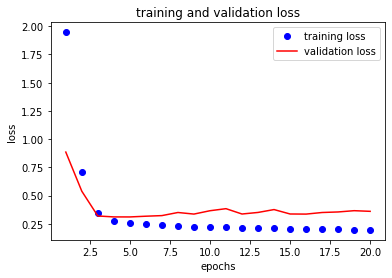

In [7]:
# simple ML approach
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

# build model
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback//step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

# configure model
model.compile(optimizer=RMSprop(), loss='mae')

# train model
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, 
                              validation_data=val_gen, validation_steps=val_steps, verbose=0)

# plot losses (MAE in this case)
history_dict = history.history
loss         = history_dict['loss']
val_loss     = history_dict['val_loss']
epochs       = range(1, len(loss)+1)

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'r', label='validation loss')
plt.title('training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

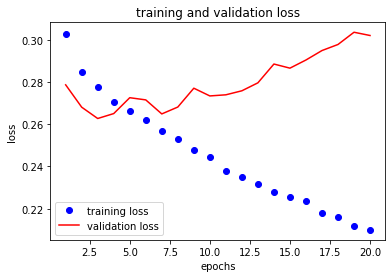

In [8]:
# 1st recurrent approach: use GRU layers (faster but less powerful than LSTM)
from keras.layers import GRU, Dense
from keras.models import Sequential
from keras.optimizers import RMSprop

# build model
model = Sequential()
model.add(GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(Dense(1))

# configure model
model.compile(optimizer=RMSprop(), loss='mae')

# train model
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, 
                              validation_data=val_gen, validation_steps=val_steps, verbose=0)

# plot losses (or MAE in this case)
history_dict = history.history
loss         = history_dict['loss']
val_loss     = history_dict['val_loss']
epochs       = range(1, len(loss)+1)

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'r', label='validation loss')
plt.title('training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


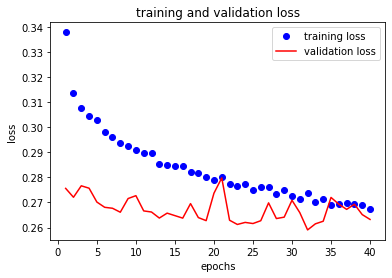

In [33]:
# 1st approach has obvious overfitting issue, so we can add dropout as a soln
# 2nd recurrent approach: use dropout-regularized GRU layers
from keras.layers import GRU, Dense
from keras.models import Sequential
from keras.optimizers import RMSprop

# build model
model = Sequential()
model.add(GRU(32, dropout=0.2, recurrent_dropout=0.2, input_shape=(None, float_data.shape[-1])))
model.add(Dense(1))

# configure model
model.compile(optimizer=RMSprop(), loss='mae')

# train model
# double the epoch numbers cuz regularization w/ dropout takes longer to fully converge
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=40, 
                              validation_data=val_gen, validation_steps=val_steps, verbose=0)

# plot losses (or MAE in this case)
history_dict = history.history
loss         = history_dict['loss']
val_loss     = history_dict['val_loss']
epochs       = range(1, len(loss)+1)

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'r', label='validation loss')
plt.title('training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


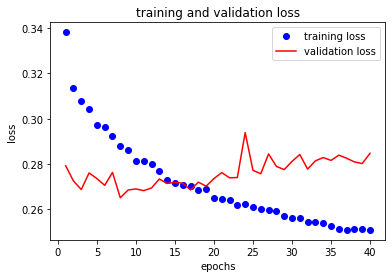

In [6]:
# 2nd approach solves overfitting issue, but hits a performance bottleneck
# so we can increase model capacity by adding more layers for improvement
# 3rd recurrent approach: use dropout-regularized & stacked GRU layers
from keras.layers import GRU, Dense
from keras.models import Sequential
from keras.optimizers import RMSprop

# build model
# for recurrent network: (1) the same dropout mask should be applied at each timestep;
#                        (2) to regularize, a temporally constant dropout mask should be 
#                            applied to the inner recurrent activations of the layer 
model = Sequential()
model.add(GRU(32, dropout=0.1, recurrent_dropout=0.5, return_sequences=True, 
                     input_shape=(None, float_data.shape[-1])))
model.add(GRU(64, activation='relu', dropout=0.1, recurrent_dropout=0.5))
model.add(Dense(1))

# configure model
model.compile(optimizer=RMSprop(), loss='mae')

# train model
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=40, 
                              validation_data=val_gen, validation_steps=val_steps, verbose=0)

# plot losses (or MAE in this case)
history_dict = history.history
loss         = history_dict['loss']
val_loss     = history_dict['val_loss']
epochs       = range(1, len(loss)+1)

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'r', label='validation loss')
plt.title('training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

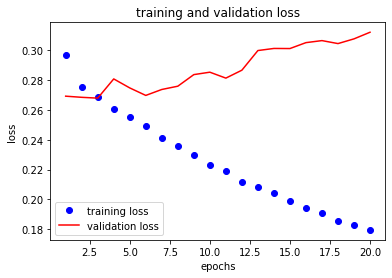

In [10]:
# 4th recurrent approach: bidirectional GRU approach
from keras.layers import Bidirectional, Dense
from keras.models import Sequential
from keras.optimizers import RMSprop

# build model 
model = Sequential()
model.add(Bidirectional(GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(Dense(1))

# configure model
model.compile(optimizer=RMSprop(), loss='mae')

# train model
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, 
                              validation_data=val_gen, validation_steps=val_steps, verbose=0)

# plot losses (or MAE in this case)
history_dict = history.history
loss         = history_dict['loss']
val_loss     = history_dict['val_loss']
epochs       = range(1, len(loss)+1)

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'r', label='validation loss')
plt.title('training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

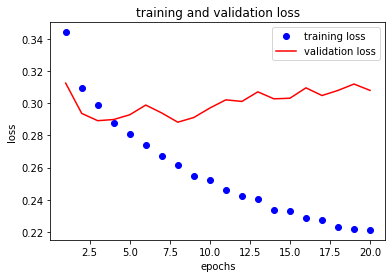

In [11]:
# 5th recurrent approach: 1D convolutional base and GRU layer approach
from keras.layers import GRU, Dense, Conv1D, MaxPooling1D
from keras.models import Sequential
from keras.optimizers import RMSprop

# build model 
model = Sequential()
model.add(Conv1D(32, 5, activation='relu', input_shape=(None, float_data.shape[-1])))
model.add(MaxPooling1D(3))
model.add(Conv1D(32, 5, activation='relu'))
model.add(GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(Dense(1))

# configure model
model.compile(optimizer=RMSprop(), loss='mae')

# train model
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, 
                              validation_data=val_gen, validation_steps=val_steps, verbose=0)

# plot losses (or MAE in this case)
history_dict = history.history
loss         = history_dict['loss']
val_loss     = history_dict['val_loss']
epochs       = range(1, len(loss)+1)

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'r', label='validation loss')
plt.title('training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()